In [17]:
import numpy as np
import json
import cvxpy as cp
from pathlib import Path
import matplotlib.pyplot as plt

from src.problems.utils import sample_data_for_group
from src.problems.problems import (
    _compute_consumer_optimal_solution_cvar,
    _compute_consumer_optimal_solution_mean,
    _compute_consumer_optimal_solution_min
)

In [3]:
DATA_PATH_ROOT = Path("../../data")

In [4]:
# load data
with open(DATA_PATH_ROOT / "amazon_predictions.npy", "rb") as f:
    REL_MATRIX = np.load(f)

with open(DATA_PATH_ROOT / "amazon_user_groups.json", "r") as f:
    GROUPS_MAP = json.load(f)

In [93]:
N_CONSUMERS = 100
N_PRODUCERS = 100
GROUP_KEY = "usage_group"
K_REC = 10
SOLVER = cp.SCIP
GAMMA = 1
ALPHA = 0.95

In [79]:
rel_matrix_sampled, consumer_ids, group_assignments = sample_data_for_group(
    n_consumers=N_CONSUMERS,
    n_producers=N_PRODUCERS,
    groups_map=GROUPS_MAP,
    group_key=GROUP_KEY,
    data=REL_MATRIX,
    naive_sampling=True,
    seed=42,
)

In [94]:
min_allocations = _compute_consumer_optimal_solution_min(
    rel_matrix=rel_matrix_sampled,
    k_rec=K_REC,
    producer_max_min_utility=10,
    gamma=GAMMA,
    solver=SOLVER
)

mean_allocations = _compute_consumer_optimal_solution_mean(
    rel_matrix=rel_matrix_sampled,
    k_rec=K_REC,
    producer_max_min_utility=10,
    gamma=GAMMA,
    solver=SOLVER
)

In [95]:
cvar_allocations =_compute_consumer_optimal_solution_cvar(
    rel_matrix=rel_matrix_sampled,
    k_rec=K_REC,
    producer_max_min_utility=10,
    gamma=GAMMA,
    group_assignments=group_assignments,
    alpha=ALPHA,
    solver=SOLVER
)

In [96]:
# get top k indexes for rel_matrix_sampled
best_alloc = np.argsort(rel_matrix_sampled, axis=1)[:, -K_REC:]
best_alloc_vals = np.take_along_axis(rel_matrix_sampled, best_alloc, axis=1).sum(axis=1) / K_REC

In [97]:
min_vals = min_allocations[1] * rel_matrix_sampled
mean_vals = mean_allocations[1] * rel_matrix_sampled
cvar_vals = cvar_allocations[1] * rel_matrix_sampled

In [98]:
min_vals = min_vals.sum(axis=1) / 10 / best_alloc_vals
mean_vals = mean_vals.sum(axis=1) / 10 / best_alloc_vals
cvar_vals = cvar_vals.sum(axis=1) / 10 / best_alloc_vals

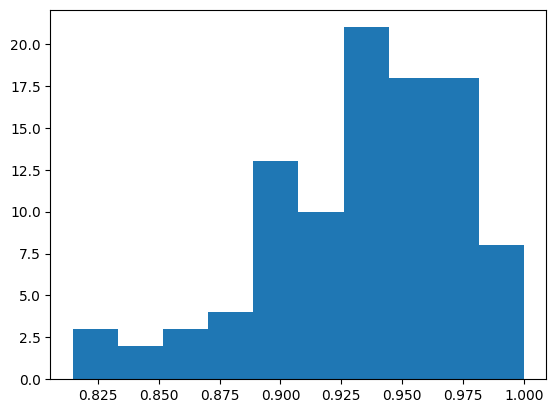

In [99]:
plt.hist(min_vals, bins=10, alpha=1, label="Min");

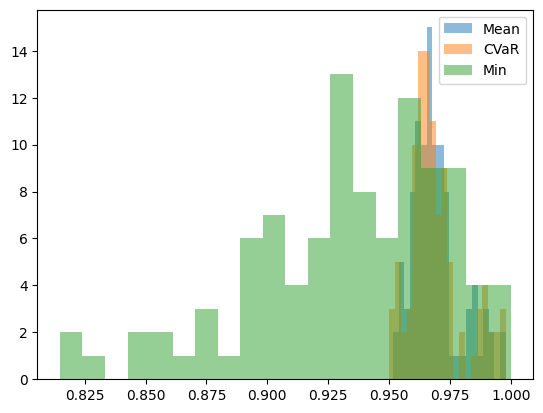

In [102]:
plt.hist(mean_vals, bins=20, alpha=0.5, label="Mean");
plt.hist(cvar_vals, bins=20, alpha=0.5, label="CVaR");
plt.hist(min_vals, bins=20, alpha=0.5, label="Min");
plt.legend()

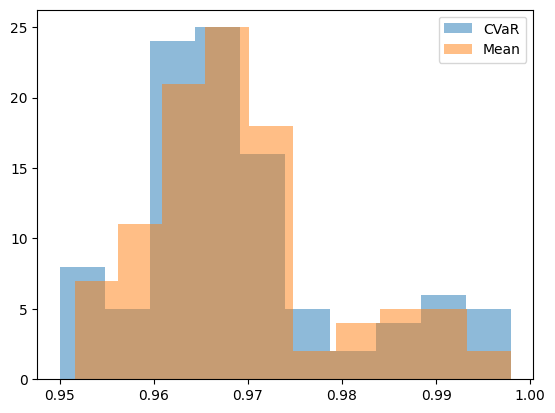

In [109]:
plt.hist(cvar_vals, bins=10, alpha=0.5, label="CVaR");
plt.hist(mean_vals, bins=10, alpha=0.5, label="Mean");
plt.legend()